In [1]:
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import sys
import pandas as pd
from torch.utils.data.dataset import Dataset
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
from preprocess import read_files

In [3]:
from collections import Counter
from itertools import repeat
import multiprocessing
import sys

import librosa
import numpy as np
import pandas as pd
from scipy import stats
import torch
from tqdm import tqdm

from vta import vta_paper

# read data

In [4]:
def get_audio_features_vta(audio: np.ndarray):
    """Generate audio features by MFCC or VTA, depending on the arguments.

    Args:
        audio (np.ndarray): raw audio data points (N, H_in)
        args (argparse.Namespace): arguments

    Returns:
        np.ndarray: extracted features (N, H_out, Frames)
    """
    zip_inputs = zip(audio, repeat(21), repeat(175))
    with multiprocessing.Pool(multiprocessing.cpu_count() // 2) as pool:
        x = pool.starmap(vta_paper, tqdm(zip_inputs, total=audio.shape[0], postfix='VTA'))
    x = np.dstack(x).T
    return x

In [5]:
train = pd.read_csv('Data/Train/data_list.csv')
drop_cols = ['ID', 'Disease category', 'PPD']
x_audio_raw, _, y_audio, _ = read_files(train, 'Data/Train/raw', 22050, 3675, drop_cols)
x_audio = get_audio_features_vta(x_audio_raw).reshape(x_audio_raw.shape[0], -1)
y_audio[~(y_audio==5)] = 0
y_audio[y_audio==5] = 1

100%|██████████| 15426/15426 [00:10<00:00, 1449.46it/s, VTA]


# Construct model

In [19]:
# Some parameters
lr = 0.0001
batch_size = 64
epoch = 100

In [7]:
class Audio_Dataset(Dataset):
  def __init__(self, dataset_x, dataset_y):
    self.x = dataset_x
    self.y = dataset_y
    self.n_samples = dataset_x.shape[0]
  def __getitem__(self, index): 
    return self.x[index], self.y[index]
  def __len__(self):
    return self.n_samples

In [8]:
class Audio_NN(nn.Module):
  def __init__(self, input_dim, output_dim, epoch):
    super(Audio_NN, self).__init__()

    self.Lin1 = nn.Linear(input_dim, 2048)
    self.Lin2 = nn.Linear(2048, 512)
    self.Lin3 = nn.Linear(512, 32)
    self.Lin4 = nn.Linear(32, 8)
    self.Lin5 = nn.Linear(8, output_dim)
    self.relu = nn.ReLU()
    self.loss = np.zeros(epoch)
  def forward(self, x):
    out = self.Lin1(x)
    out = self.relu(out)
    out = self.Lin2(out)
    out = self.Lin3(out)
    out = self.relu(out)
    out = self.Lin4(out)
    out = self.Lin5(out)
    return out

In [20]:
dataset_train = Audio_Dataset(x_audio,y_audio)
dataloader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle = False)

In [21]:
audio_nn = Audio_NN(input_dim=x_audio.shape[1], output_dim=2, epoch=epoch)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(audio_nn.parameters(),lr=lr)

In [22]:
for i in tqdm(range(epoch)):
  for id, (x, y) in enumerate(dataloader_train):
    pred = audio_nn(x.float())
    loss_value = loss(pred,y.long())

    optimizer.zero_grad()
    loss_value.backward()

    optimizer.step()
    audio_nn.loss[i] = loss_value

100%|██████████| 100/100 [14:19<00:00,  8.59s/it]


In [16]:
import matplotlib.pyplot as plt

In [47]:
torch.save(audio_nn.state_dict(), r"C:\Users\User\Desktop\AIIM\final_project\audio_model")

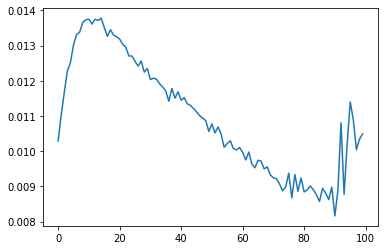

In [23]:
plt.plot(audio_nn.loss)

In [ ]:
model = Audio_NN(input_dim=x_audio.shape[1], output_dim=2, epoch=epoch)
model.load_state_dict(torch.load(r"C:\Users\User\Desktop\AIIM\final_project\audio_model"))
model.eval()

<AxesSubplot:>

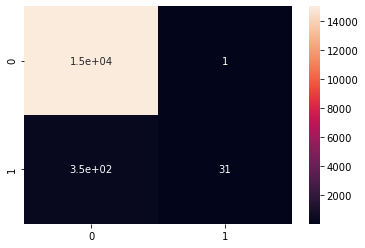

In [24]:
y_pred = audio_nn(torch.tensor(x_audio).float())
y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
cf_matrix = confusion_matrix(y_audio, y_pred)

sn.heatmap(cf_matrix, annot=True)
